In [ ]:
from google.colab import files, drive
import os
import shutil
from PIL import Image
import sys
import glob
from IPython.display import display, clear_output
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

In [ ]:
import tensorflow as tf
from tensorflow.keras.utils import image_dataset_from_directory
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, RandomFlip, RandomRotation, RandomBrightness, Rescaling, Resizing
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, Softmax
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from sklearn.metrics import classification_report, confusion_matrix

In [ ]:
!pip install keras_tuner
import keras_tuner as kt # used for hyperparameter optimisation

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 176.1/176.1 kB 2.6 MB/s eta 0:00:00


# Import Data

In [ ]:
# Kaggle keys
os.environ["KAGGLE_USERNAME"] = "lucagee"
os.environ["KAGGLE_KEY"] = "a2fbb8660c3567ac94eb3e66d1619953"

# Download Kaggle Dataset
!kaggle datasets download -d csafrit2/plant-leaves-for-image-classification

# Unzip Dataset
!unzip -q /content/plant-leaves-for-image-classification.zip

100% 6.56G/6.56G [03:53<00:00, 39.6MB/s]
100% 6.56G/6.56G [03:53<00:00, 30.2MB/s]


In [ ]:
# define funciton to build paths

def build_paths():
  paths = []

  for dir in ["train", "test", "valid"]:
    paths.append(os.path.join("/content/Plants_2", dir))

  return paths

paths = build_paths()
paths

['/content/Plants_2/train',
 '/content/Plants_2/test',
 '/content/Plants_2/valid']

In [ ]:
# Function to delete subdirectories with diseased images

def delete_diseased_dirs():
  for path in paths:
    for dir in os.listdir(path):
      if "diseased" in dir:
        shutil.rmtree(os.path.join(path, dir))

# Delete Directories containing diseased images
delete_diseased_dirs()

In [ ]:
# Function to Resize Images

def resize_images(height, width):
  indicator = 0
  for path_subdir in paths:
    for img_path in os.listdir(path_subdir):
      for img in os.listdir(os.path.join(path_subdir, img_path)):
        image_path_final = os.path.join(path_subdir, img_path, img)
        with Image.open(image_path_final) as image:
          resized_image = image.resize((height,width))
          resized_image.save(image_path_final)
          indicator += 1
          clear_output(wait=True)
          display('Images resized: ' + str(indicator))

resize_images(256,256)

'Images resized: 2273'

In [ ]:
# Data Processing Parameters
IMG_SIZE = 256

# Setup

In [ ]:
train_ds = image_dataset_from_directory("Plants_2/train", image_size=(IMG_SIZE, IMG_SIZE))
val_ds = image_dataset_from_directory("Plants_2/valid", image_size=(IMG_SIZE, IMG_SIZE))
test_ds = image_dataset_from_directory("Plants_2/test", image_size=(IMG_SIZE, IMG_SIZE), shuffle = False)

Found 2163 files belonging to 11 classes.
Found 55 files belonging to 11 classes.
Found 55 files belonging to 11 classes.


In [ ]:
CLASS_NAMES = train_ds.class_names
NUM_CLASSES = 11
true_test_labels = np.concatenate([y for x, y in test_ds], axis=0)

In [ ]:
# Hardware acceleration

AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.shuffle(512).cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [ ]:
# Function to Build Deep Learning Model
def make_model(params):
  # Hyperparameters Search Space
  DROPOUT_CONV = params.Float("Convolutional_Dropout", min_value = 0.1, max_value = 0.3, step = 0.1)
  DROPOUT_DENSE = params.Float("Dense_Dropout", min_value = 0.3, max_value = 0.5, step = 0.1)

  FILTERS = params.Int("Convolutional_Filters", min_value=16, max_value=64, step=8)

  UNITS_DENSE = params.Int("Dense_Units", min_value=8, max_value=32, step=8)

  # Build Model
  model = Sequential(
      [
          Input(shape=(IMG_SIZE, IMG_SIZE, 3)),
          Resizing(256,256),
          RandomFlip("horizontal"),
          RandomFlip("vertical"),
          RandomRotation(0.2),
          RandomBrightness(0.2),
          Rescaling(scale=1/255.0),
          Conv2D(filters=FILTERS, kernel_size=3, padding="same", activation="relu"),
          MaxPooling2D(),
          Dropout(DROPOUT_CONV),
          Conv2D(filters=FILTERS, kernel_size=3, padding="same", activation="relu"),
          MaxPooling2D(),
          Conv2D(filters=FILTERS, kernel_size=3, padding="same", activation="relu"),
          MaxPooling2D(),
          Dropout(DROPOUT_CONV),
          Flatten(),
          Dense(UNITS_DENSE),
          Dropout(DROPOUT_DENSE),
          Dense(NUM_CLASSES),
          Softmax()
               ]
  )

  # Compile Model
  model.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])

  return model

In [ ]:
# Parameters
MAX_TRIALS_TUNER = 10
EPOCHS_TUNER = 10

# Tuner
tuner = kt.RandomSearch(make_model, objective = "val_accuracy", max_trials = MAX_TRIALS_TUNER, directory = "grid_search") # Smart way to optimise hyperparameters
tuner.search(train_ds, validation_data = val_ds, epochs = EPOCHS_TUNER)
tuner.results_summary()

Trial 10 Complete [00h 01m 50s]
val_accuracy: 0.8181818127632141

Best val_accuracy So Far: 0.8545454740524292
Total elapsed time: 00h 13m 42s
Results summary
Results in grid_search/untitled_project
Showing 10 best trials
Objective(name="val_accuracy", direction="max")

Trial 02 summary
Hyperparameters:
Convolutional_Dropout: 0.1
Dense_Dropout: 0.4
Convolutional_Filters: 64
Dense_Units: 32
Score: 0.8545454740524292

Trial 00 summary
Hyperparameters:
Convolutional_Dropout: 0.2
Dense_Dropout: 0.4
Convolutional_Filters: 16
Dense_Units: 32
Score: 0.8363636136054993

Trial 01 summary
Hyperparameters:
Convolutional_Dropout: 0.2
Dense_Dropout: 0.3
Convolutional_Filters: 24
Dense_Units: 32
Score: 0.8181818127632141

Trial 08 summary
Hyperparameters:
Convolutional_Dropout: 0.1
Dense_Dropout: 0.3
Convolutional_Filters: 40
Dense_Units: 32
Score: 0.8181818127632141

Trial 09 summary
Hyperparameters:
Convolutional_Dropout: 0.1
Dense_Dropout: 0.5
Convolutional_Filters: 56
Dense_Units: 32
Score: 0.81

In [ ]:
best_params = tuner.get_best_hyperparameters()[0]
best_params.get_config()["values"]
model = tuner.hypermodel.build(best_params)
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resizing_1 (Resizing)       (None, 256, 256, 3)       0         
                                                                 
 random_flip_2 (RandomFlip)  (None, 256, 256, 3)       0         
                                                                 
 random_flip_3 (RandomFlip)  (None, 256, 256, 3)       0         
                                                                 
 random_rotation_1 (RandomRo  (None, 256, 256, 3)      0         
 tation)                                                         
                                                                 
 random_brightness_1 (Random  (None, 256, 256, 3)      0         
 Brightness)                                                     
                                                                 
 rescaling_1 (Rescaling)     (None, 256, 256, 3)      

In [ ]:
EPOCHS_FIT = 50
history = model.fit(train_ds, validation_data=val_ds, epochs=EPOCHS_FIT)

Epoch 1/50
68/68 [==============================] - 14s 178ms/step - loss: 2.2178 - accuracy: 0.2279 - val_loss: 2.0827 - val_accuracy: 0.1818
Epoch 2/50
68/68 [==============================] - 12s 173ms/step - loss: 1.9307 - accuracy: 0.3329 - val_loss: 1.7010 - val_accuracy: 0.4364
Epoch 3/50
68/68 [==============================] - 12s 171ms/step - loss: 1.7147 - accuracy: 0.4050 - val_loss: 1.3196 - val_accuracy: 0.5091
Epoch 4/50
68/68 [==============================] - 11s 168ms/step - loss: 1.5813 - accuracy: 0.4702 - val_loss: 1.1335 - val_accuracy: 0.6909
Epoch 5/50
68/68 [==============================] - 11s 167ms/step - loss: 1.5101 - accuracy: 0.4868 - val_loss: 1.1394 - val_accuracy: 0.6727
Epoch 6/50
68/68 [==============================] - 11s 167ms/step - loss: 1.3267 - accuracy: 0.5557 - val_loss: 0.9075 - val_accuracy: 0.7273
Epoch 7/50
68/68 [==============================] - 11s 167ms/step - loss: 1.1754 - accuracy: 0.6112 - val_loss: 0.7236 - val_accuracy: 0.7818

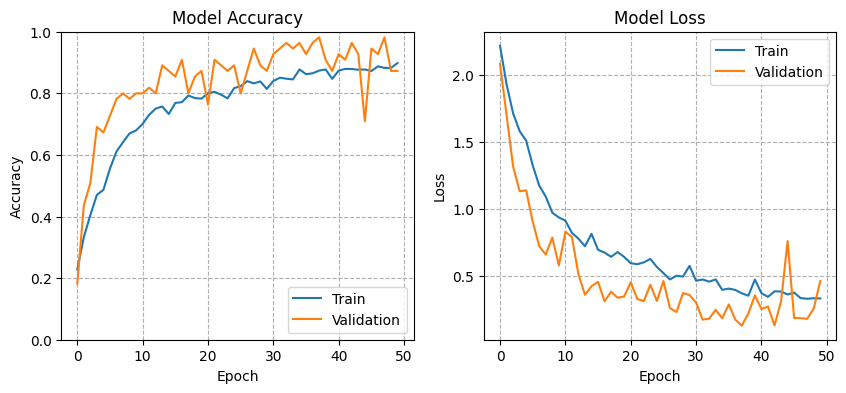

In [ ]:
plt.figure(figsize=(10,4))

plt.subplot(1,2,1)
plt.ylim(0,1)
plt.grid(True, "both", linestyle="--")
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='lower right')

plt.subplot(1,2,2)
plt.grid(True, "both", linestyle="--")
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')

plt.show()

In [ ]:
# Evaluate Performance on Test Dataset
results = model.evaluate(test_ds)
pred_test_labels = np.argmax(model.predict(test_ds), axis = 1)

2/2 [==============================] - 0s 22ms/step


In [ ]:
true_test_labels = [CLASS_NAMES[label_int] for label_int in true_test_labels]
pred_test_labels = [CLASS_NAMES[label_int] for label_int in pred_test_labels]

report = classification_report(true_test_labels, pred_test_labels)
print(report)

                                  precision    recall  f1-score   support

Alstonia Scholaris healthy (P2b)       1.00      1.00      1.00         5
             Arjun healthy (P1b)       0.83      1.00      0.91         5
              Basil healthy (P8)       1.00      1.00      1.00         5
           Chinar healthy (P11a)       1.00      1.00      1.00         5
             Gauva healthy (P3a)       1.00      1.00      1.00         5
             Jamun healthy (P5a)       1.00      1.00      1.00         5
          Jatropha healthy (P6a)       1.00      0.80      0.89         5
            Lemon healthy (P10a)       1.00      1.00      1.00         5
             Mango healthy (P0a)       0.71      1.00      0.83         5
       Pomegranate healthy (P9a)       1.00      0.60      0.75         5
  Pongamia Pinnata healthy (P7a)       1.00      1.00      1.00         5

                        accuracy                           0.95        55
                       macro avg    